In [1]:
import pytorch_lightning as L
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint

import re
import os
import cv2
import copy
import math
import warnings
import numpy as np
import matplotlib.pyplot as plt
import urllib.request as urllib
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from torchmetrics.text import ROUGEScore

from torch.nn.utils.rnn import pad_sequence
from torchvision.transforms.v2 import (
    Compose,
    Resize,
    ToTensor,
    Normalize,
    RandomHorizontalFlip,
    RandomAffine,
    RandomAutocontrast
)
try:
    from torchvision.transforms.v2 import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

from swin_transformer import swin_t,swin_l,swin_b,swin_s
from torchvision.datasets.utils import download_and_extract_archive
from llama3_transformer_block import *
torch.set_float32_matmul_precision('high')
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

c:\Users\Admin\anaconda3\envs\dfine\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)
os.makedirs("experiment/model", exist_ok=True)
EXPERIMENT_DIR = "experiment/"

In [3]:
ANNOTATION_PATH = "experiment/dataset/Flickr8k.token_copy.txt"
IMAGE_PATH = "experiment/dataset/Flicker8k_Dataset"

In [4]:
METRIC_TO_MONITOR = "val_loss"
METRIC_MODE       = "min"

In [5]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 1369326798


In [6]:
START_TOKEN = "<sos>"
END_TOKEN = "<eos>"
PAD_TOKEN = "<pad>"
OOV_TOKEN = "<unk>"

In [7]:
MAX_SEQUENCE = 30
IMAGE_SIZE = 224

In [8]:
TEMPERATURE = 0.1
TOP_P = 0.9

In [9]:
NUM_HEAD = 32
NUM_KV_HEAD = 8
NUM_LAYER = 4
EMBED_DIM = 640
HEAD_DIM = EMBED_DIM // NUM_HEAD
ROPE_BASE = 10000
MLP_SCALE = 3.5
DROPOUT = math.sin(math.sqrt(math.e * math.pi))
EPS_NORM = 1e-5

In [10]:
MAX_EPOCH = 42
BATCH_SIZE = 32
LEARNING_RATE = 3.1e-4
REDUCE_LR_FACTOR = 0.69
Vocab_size = 5000

In [11]:
MILESTONES = 1. / math.sqrt(MAX_EPOCH) * (
    np.array(
        [m for m in range(1, int(math.sqrt(MAX_EPOCH)))]
    )
)

## **Dataset**

In [12]:
# DATASET_URL = {
#     "image" : (
#         "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip",
#         "Flickr8k_Dataset.zip",
#     ),
#     "text"   : (
#         "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip",
#         "Flickr8k_text.zip",
#     ),
# }

In [13]:
# for dat in DATASET_URL.values():
#     url, filename = dat
#     download_and_extract_archive(
#         url,
#         "experiment/dataset",
#         filename=filename,
#     )
#     os.remove(os.path.join("experiment/dataset", filename))

#### **Image Transform**

In [14]:
class ToRGB(object):
    def __call__(self, image):
        assert 'PIL' in str(type(image)), "Expected PIL Image"
        return image.convert("RGB")

In [15]:
TRANSFORM = Compose(
    [
        Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=BICUBIC),
        ToRGB(),
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

TRANSFORM_AUGMENTATION = Compose(
    [
        Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=BICUBIC),
        ToRGB(),
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        RandomHorizontalFlip(),
        RandomAutocontrast(p=0.25),
        RandomAffine(
            degrees=22.5,
            scale=(math.sqrt(0.5 * math.pi), math.sqrt(math.pi)),
            shear=5.,
        ),
    ]
)

#### **Tokenizer**

In [16]:
import sentencepiece as spm
import os
import string

class BPETokenizer:
    def __init__(self, annotation_path, model_prefix="bpe", vocab_size=1500):
        self.model_prefix = model_prefix
        self.vocab_size = vocab_size
        self.model_file = f"{model_prefix}.model"

        # Kiểm tra nếu mô hình BPE đã tồn tại
        if not os.path.exists(self.model_file):
            self._train_model(annotation_path)
        
        # Load mô hình BPE đã huấn luyện
        self.sp = spm.SentencePieceProcessor(model_file=self.model_file)

    def _train_model(self, annotation_path):
        """Huấn luyện mô hình BPE từ dữ liệu văn bản."""
        with open(annotation_path, "r", encoding="utf-8") as f:
            lines = [line.strip().split("\t")[-1].lower() for line in f.readlines()]
        
        # Ghi dữ liệu văn bản vào file tạm để huấn luyện
        temp_file = "temp_corpus.txt"
        with open(temp_file, "w", encoding="utf-8") as f:
            f.write("\n".join(lines))
        
        # Huấn luyện mô hình BPE
        spm.SentencePieceTrainer.train(
            input=temp_file, model_prefix=self.model_prefix, vocab_size=self.vocab_size, 
            pad_id=0, unk_id=1, bos_id=2, eos_id=3
        )
        
        # Xóa file tạm
        os.remove(temp_file)

    def encode(self, text):
        """Mã hóa văn bản thành các token ID."""
        text = text.lower()
        text = text.translate(str.maketrans("", "", string.punctuation))  # Loại bỏ dấu câu
        return self.sp.encode(text, out_type=int)

    def decode(self, token_ids):
        """Giải mã danh sách token ID về văn bản gốc."""
        return self.sp.decode(token_ids)

    def __len__(self):
        """Trả về số lượng từ vựng trong tokenizer."""
        return len(self.sp)

# Ví dụ sử dụng

bpe_tokenizer = BPETokenizer(ANNOTATION_PATH)

# text = "A motorcycle driver dress in orange gear swerve to the right ."
# tokens = bpe_tokenizer.encode(text)
# decoded_text = bpe_tokenizer.decode(tokens)

# print("Original Text:", text)
# print("Encoded Tokens:", tokens)
# print("Decoded Text:", decoded_text)

In [17]:
Tokenizer = BPETokenizer(ANNOTATION_PATH)
print(f"Vocab size: {Tokenizer.vocab_size}")

Vocab size: 1500


In [18]:
import torch

def tokenize(text, tokenizer = Tokenizer, max_sequence = 30, pad_token=PAD_TOKEN, start_token=START_TOKEN, end_token=END_TOKEN):

    sos_token = tokenizer.sp.piece_to_id(start_token)
    eos_token = tokenizer.sp.piece_to_id(end_token)
    pad_token = tokenizer.sp.piece_to_id(pad_token)

    tokens = [sos_token] + tokenizer.encode(text) + [eos_token]

    result = torch.full((max_sequence,), pad_token, dtype=torch.long)

    # Cắt hoặc giữ nguyên tokens trong giới hạn max_sequence
    if len(tokens) > max_sequence:
        tokens = tokens[:max_sequence]
        tokens[-1] = eos_token

    result[:len(tokens)] = torch.tensor(tokens)

    return result.long()


#### **Image Captioning Dataset**

In [19]:
import os
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image

class Flickr8KDataset(Dataset):
    def __init__(self, split):
        assert split in ["train", "val", "test", "inference"], f"Invalid split: {split}"

        self.data = []
        
        try:
            with open(ANNOTATION_PATH, "r") as caption_file:
                for line in caption_file:
                    img_name, caption = line.rstrip("\n").split("\t")
                    img_name = img_name.split("#")[0]
                    img_name = os.path.join(IMAGE_PATH, img_name.strip())

                    if img_name.endswith(".jpg"):
                        self.data.append((img_name, caption.strip()))
        except Exception as e:
            raise RuntimeError(f"Error reading annotation file: {e}")

        # Shuffle dữ liệu đồng bộ
        random.seed(SEED)
        random.shuffle(self.data)

        # Chia tập dữ liệu
        n_data = len(self.data)
        split_ratios = {"train": (0.0, 0.8), "val": (0.8, 0.9), "test": (0.9, 1.0)}
        start, end = split_ratios.get(split, (0.0, 1.0))
        start_idx, end_idx = int(n_data * start), int(n_data * end)

        self.data = self.data[start_idx:end_idx]
        self.transform = TRANSFORM_AUGMENTATION if split == "train" else TRANSFORM
        self.split = split

    def load_image(self, img_path):
        """Hàm mở ảnh và áp dụng transform"""
        image = Image.open(img_path).convert("RGB")
        return self.transform(image)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path, caption = self.data[index]
        image = self.load_image(img_path)
        caption = tokenize(caption)
        return image, caption

    def raw_image(self, index):
        """Chỉ dùng cho inference"""
        if self.split != "inference":
            raise ValueError("raw_image() chỉ dùng cho inference mode.")
        return Image.open(self.data[index][0]).convert("RGB")

    def inference_data(self, index):
        """Chỉ dùng cho inference"""
        if self.split != "inference":
            raise ValueError("inference_data() chỉ dùng cho inference mode.")
        return self.load_image(self.data[index][0])

    def plot_sample(self, index=None):
        """Hiển thị một ảnh trong dataset kèm caption"""
        if index is None:
            index = random.randint(0, len(self.data) - 1)

        img_path, caption = self.data[index]
        image = Image.open(img_path).convert("RGB")

        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis("off")
        plt.title(caption, fontsize=12)
        plt.show()

def collate_fn(batch):
    """Hàm padding batch cho DataLoader"""
    images, captions = zip(*batch)
    images = torch.stack(images)
    captions = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=bpe_tokenizer.sp.pad_id())
    return images, captions


### **Load**

In [20]:
TrainDataset = Flickr8KDataset('train')
ValDataset = Flickr8KDataset('val')
TestDataset = Flickr8KDataset('test')

## **Model**

In [21]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.scores = []

    def update(self, val):
        self.scores.append(val)

    def show(self):
        if len(self.scores) == 0:
            return 0  
        return torch.tensor(self.scores, dtype=torch.float32).mean()


In [22]:
MODEL_NAME = "SwinLlama3"

In [23]:
class ImageCaptioning(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.batch_size = BATCH_SIZE
        self.max_epoch = MAX_EPOCH
        self.lr = LEARNING_RATE
        self.lr_now = self.lr * 1e3

        MLP = FeedForward(
            gate_proj=nn.Linear(EMBED_DIM, int(EMBED_DIM * MLP_SCALE), bias=False),
            down_proj=nn.Linear(int(EMBED_DIM * MLP_SCALE), EMBED_DIM, bias=False),
            up_proj=nn.Linear(EMBED_DIM, int(EMBED_DIM * MLP_SCALE), bias=False),
        )

        FEATURE_EXTRACTOR = swin_t(num_classes = EMBED_DIM)
        SELF_ATTENTION = CausalSelfAttention(
            embed_dim=EMBED_DIM,
            num_heads=NUM_HEAD,
            num_kv_heads=NUM_KV_HEAD,
            head_dim=HEAD_DIM,
            q_proj=nn.Linear(EMBED_DIM, EMBED_DIM, bias=False),
            k_proj=nn.Linear(EMBED_DIM, NUM_KV_HEAD * HEAD_DIM, bias=False),
            v_proj=nn.Linear(EMBED_DIM, NUM_KV_HEAD * HEAD_DIM, bias=False),
            output_proj=nn.Linear(EMBED_DIM, EMBED_DIM, bias=False),
            pos_embeddings=RotaryPositionalEmbedding(
                dim=HEAD_DIM,
                max_seq_len=1,
                base=ROPE_BASE,
            ),
            max_seq_len=1,
            attn_dropout=DROPOUT,
        )
        ENCODER_LAYER = TransformerEncoderLayer(
            attn=SELF_ATTENTION,
            mlp=copy.deepcopy(MLP),
            sa_norm=RMSNorm(dim=EMBED_DIM, eps=EPS_NORM),
            mlp_norm=RMSNorm(dim=EMBED_DIM, eps=EPS_NORM),
        )
        self.encoder = TransformerEncoder(
            feature_extractor=FEATURE_EXTRACTOR,
            layer=ENCODER_LAYER,
            num_layers=NUM_LAYER,
            max_seq_len=MAX_SEQUENCE,
            num_heads=NUM_HEAD,
            head_dim=HEAD_DIM,
            norm=RMSNorm(EMBED_DIM, eps=EPS_NORM),
        )

        # LLaMA 3
        TOKEN_EMBEDDING = nn.Embedding(Vocab_size, EMBED_DIM)
        ROPE = RotaryPositionalEmbedding(
            dim=HEAD_DIM,
            max_seq_len=MAX_SEQUENCE,
            base=ROPE_BASE,
        )
        SELF_ATTENTION_1 = CausalSelfAttention(
            embed_dim=EMBED_DIM,
            num_heads=NUM_HEAD,
            num_kv_heads=NUM_KV_HEAD,
            head_dim=HEAD_DIM,
            q_proj=nn.Linear(EMBED_DIM, EMBED_DIM, bias=False),
            k_proj=nn.Linear(EMBED_DIM, NUM_KV_HEAD * HEAD_DIM, bias=False),
            v_proj=nn.Linear(EMBED_DIM, NUM_KV_HEAD * HEAD_DIM, bias=False),
            output_proj=nn.Linear(EMBED_DIM, EMBED_DIM, bias=False),
            pos_embeddings=ROPE,
            max_seq_len=MAX_SEQUENCE,
            attn_dropout=DROPOUT,
        )
        SELF_ATTENTION_2 = CausalSelfAttention(
            embed_dim=EMBED_DIM,
            num_heads=NUM_HEAD,
            num_kv_heads=NUM_KV_HEAD,
            head_dim=HEAD_DIM,
            q_proj=nn.Linear(EMBED_DIM, EMBED_DIM, bias=False),
            k_proj=nn.Linear(EMBED_DIM, NUM_KV_HEAD * HEAD_DIM, bias=False),
            v_proj=nn.Linear(EMBED_DIM, NUM_KV_HEAD * HEAD_DIM, bias=False),
            output_proj=nn.Linear(EMBED_DIM, EMBED_DIM, bias=False),
            pos_embeddings=ROPE,
            max_seq_len=MAX_SEQUENCE,
            attn_dropout=DROPOUT,
        )
        DECODER_LAYER = TransformerDecoderLayer(
            attn1=SELF_ATTENTION_1,
            attn2=SELF_ATTENTION_2,
            mlp=copy.deepcopy(MLP),
            sa_norm_x1=RMSNorm(dim=EMBED_DIM, eps=EPS_NORM),
            sa_norm_x2=RMSNorm(dim=EMBED_DIM, eps=EPS_NORM),
            mlp_norm=RMSNorm(dim=EMBED_DIM, eps=EPS_NORM),
        )
        OUT_PROJECTION = nn.Linear(EMBED_DIM, Vocab_size, bias=False)
        self.decoder = TransformerDecoder(
            tok_embedding=TOKEN_EMBEDDING,
            layer=DECODER_LAYER,
            num_layers=NUM_LAYER,
            max_seq_len=MAX_SEQUENCE,
            num_heads=NUM_HEAD,
            head_dim=HEAD_DIM,
            norm=RMSNorm(EMBED_DIM, eps=EPS_NORM),
            output=OUT_PROJECTION,
        )

        self.automatic_optimization = False

        self.train_loss = list()
        self.val_loss = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.test_rogue = ROUGEScore()

        self.sanity_check_counter = 1

    def forward(self, image, caption):
        image_feature = self.encoder(image)
        return self.decoder(caption, image_feature)

    def captionize(self, image, temperature=TEMPERATURE, top_p=TOP_P):
        assert image.shape[0] == 1

        self.encoder.setup_caches(max_batch_size=1)
        encoder_feat = self.encoder(
            image,
            input_pos=torch.tensor([0], device=self.device),
        )
        self.encoder.clear_caches()

        self.decoder.setup_caches(max_batch_size=1)

        pred_token = bpe_tokenizer.sp.bos_id()
        token = [pred_token] + [bpe_tokenizer.sp.pad_id()] * (MAX_SEQUENCE)
        for index in range(MAX_SEQUENCE):
            caption = torch.LongTensor([pred_token]).unsqueeze(0).to(self.device)

            pred_token = self.decoder(
                caption,
                encoder_feat,
                input_pos=torch.tensor([index], device=self.device),
            )

            if temperature > 0:
                # Apply temperature -> make distribution softer (?)
                pred_token = (pred_token / temperature).softmax(-1)[0]
                # Sampling
                psort, pidx = torch.sort(pred_token, dim= -1, descending=True)
                psum = torch.cumsum(psort, dim=-1)
                psort[psum - psort > top_p] = 0.
                psort.div_(psort.sum(dim=-1, keepdim=True))
                pred_token = torch.multinomial(psort, num_samples=1)
                pred_token = torch.gather(pidx, -1, pred_token).transpose(0, 1)
            else:
                pred_token = pred_token.softmax(-1).argmax(2)

            pred_token = pred_token.item()
            token[index + 1] = pred_token

            if pred_token == bpe_tokenizer.sp.eos_id():
                break

        self.decoder.clear_caches()

        return self.postprocess_text(bpe_tokenizer.decode(token))

    def postprocess_text(self, text):
        text = text.replace(START_TOKEN, "")
        text = text.replace(END_TOKEN, "")
        text = text.replace(PAD_TOKEN, "")
        text = re.sub(r'\s([,.!?])', r'\1', text)
        text = '. '.join(map(lambda s: s.strip().capitalize(), text.split('.')))
        return text

    def training_step(self, batch, batch_nb):
        image, caption = batch

        pred = self(image, caption[:, :-1])
        pred = pred.view(-1, pred.shape[-1])
        caption = caption[:, 1:].reshape(caption.shape[0] * (caption.shape[-1] - 1))

        loss = F.cross_entropy(pred, caption, ignore_index=bpe_tokenizer.sp.pad_id())

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        torch.nn.utils.clip_grad_norm_(
            self.parameters(),
            math.log2(math.sqrt(math.e * math.tau) * math.pi),
        )
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.train_loss_recorder.update(loss.data)

    def on_train_epoch_end(self):
        sch = self.lr_schedulers()
        sch.step()
        self.train_loss.append(self.train_loss_recorder.show().data.cpu().numpy())
        self.train_loss_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        image, caption = batch

        pred = self(image, caption[:, :-1])
        pred = pred.view(-1, pred.shape[-1])
        caption = caption[:, 1:].reshape(caption.shape[0] * (caption.shape[-1] - 1))

        loss = F.cross_entropy(pred, caption, ignore_index=bpe_tokenizer.sp.pad_id())

        if self.sanity_check_counter == 0:
            self.log("val_loss", loss, prog_bar=True)
            self.val_loss_recorder.update(loss.data)

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            loss = self.val_loss_recorder.show().data.cpu().numpy()
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now != lr_now_:
                self.lr_now = lr_now_
                str_report = f"[{MODEL_NAME}] Learning Rate Changed: {lr_now_}"
                str_report += f"- Epoch: {self.current_epoch}"
                print(str_report)
            self.val_loss.append(loss)
            self.val_loss_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        image, caption = batch

        N_BATCH = image.shape[0]

        rogue1_fmeasure = list()

        for id in range(N_BATCH):
            pred = self.captionize(image[id].unsqueeze(0))
            target = self.postprocess_text(
                Tokenizer.decode(
                    caption[id].cpu()
                    .detach()
                    .numpy()
                    .tolist()
                )
            )
            rogue1_fmeasure.append(
                self.test_rogue(pred, target)['rouge1_fmeasure']
                .cpu()
                .detach()
                .numpy()
                .tolist()
            )

        rogue1_fmeasure = np.array(rogue1_fmeasure).mean()
        self.log("ROGUE-1 F-measure", rogue1_fmeasure, prog_bar=True, logger=True)

    def on_train_end(self):
        # Loss
        img_file = f"experiment/training/{MODEL_NAME}_loss_plot.png"
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(img_file)
        plt.clf()
        img = cv2.imread(img_file)
    

    def train_dataloader(self):
        return data.DataLoader(
            TrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=0,
        )

    def val_dataloader(self):
        return data.DataLoader(
            ValDataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=0,
        )

    def test_dataloader(self):
        return data.DataLoader(
            TestDataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=0,
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), self.lr)

        lr_scheduler = {
            "scheduler": optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[int(self.max_epoch * ms) for ms in MILESTONES],
                gamma=REDUCE_LR_FACTOR,
            ),
            "name": "lr_scheduler",
        }

        return [optimizer], [lr_scheduler]

In [24]:
MODEL_NAME = "SwinLlama3"
BEST_MODEL_PATH = os.path.join(
    EXPERIMENT_DIR,
    f"model/{MODEL_NAME}_best.ckpt",
)
LAST_MODEL_PATH = os.path.join(
    EXPERIMENT_DIR,
    "model/last.ckpt",
)

## **Training**

In [25]:
def _train_loop():
    seed_everything(SEED, workers=True)

    print(MODEL_NAME)
    model = ImageCaptioning()

    callbacks = list()

    checkpoint = ModelCheckpoint(
        monitor=METRIC_TO_MONITOR,
        dirpath=f"{EXPERIMENT_DIR}/model",
        mode=METRIC_MODE,
        filename=f"{MODEL_NAME}_best",
        save_last=True,
    )
    callbacks.append(checkpoint)

    # if os.path.exists(BEST_MODEL_PATH):
    #     ckpt_path = BEST_MODEL_PATH
    # else:
    ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=MAX_EPOCH,
        logger=False,
        callbacks=callbacks,
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)

_train_loop()

Seed set to 1369326798


SwinLlama3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | encoder    | TransformerEncoder | 49.3 M | train
1 | decoder    | TransformerDecoder | 31.8 M | train
2 | test_rogue | ROUGEScore         | 0      | train
----------------------------------------------------------
81.1 M    Trainable params
28.8 K    Non-trainable params
81.1 M    Total params
324.440   Total estimated model params size (MB)
367       Modules in train mode
0         Modules in eval mode


Epoch 30:  20%|█▉        | 10/51 [00:05<00:21,  1.87it/s, train_loss=0.470, val_loss=3.670]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

## **Testing**

In [ ]:
def _test_loop():
    trainer = Trainer(accelerator='auto', logger=False)
    model = ImageCaptioning()
    trainer.test(
        model=model,
        ckpt_path=LAST_MODEL_PATH if os.path.exists(LAST_MODEL_PATH) else None,
    )

_test_loop()

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at experiment/model/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at experiment/model/last.ckpt


Testing DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]y aand with on wear pe  wom ⁇  aand with ⁇  aand with on wear pe  wom ⁇  aand with ⁇  aand with


IndexError: Out of range: piece id is out of range.

## **Inference**

### **Utils**

In [29]:
INFERENCE_SAMPLE = 9
MAX_CHAR = 50

### **Initialize**

In [26]:
model = ImageCaptioning.load_from_checkpoint(LAST_MODEL_PATH)
model.eval()

InferenceDataset = Flickr8KDataset('inference')

#### **From Dataset**

<Figure size 640x480 with 0 Axes>

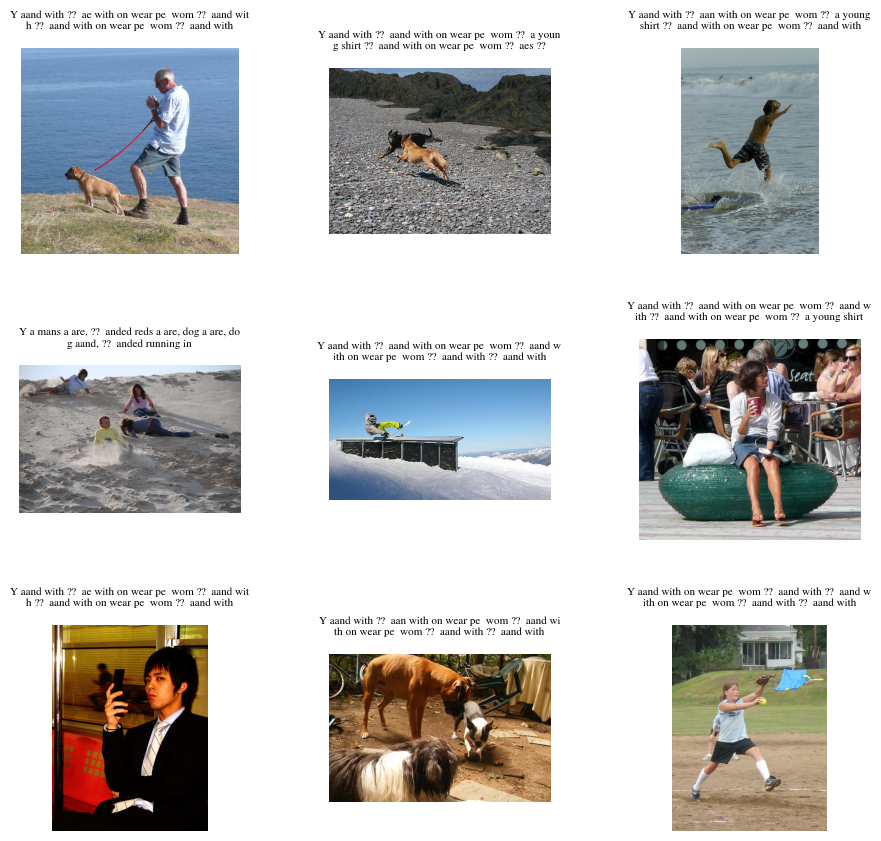

In [30]:
plt.clf()
fig = plt.figure()
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=math.sqrt(2),
    top=math.sqrt(3),
    wspace=0.4,
    hspace=0.4,
)

N_SAMPLE = len(InferenceDataset)
SELECTED_SAMPLE = [
    random.randint(0, N_SAMPLE - 1) for _ in range(INFERENCE_SAMPLE)
]

for index, sample_idx in enumerate(SELECTED_SAMPLE):
    image = InferenceDataset.inference_data(sample_idx)
    image = image.to(
        "cuda" if torch.cuda.is_available() else "cpu"
    ).unsqueeze(0)

    caption = model.captionize(image)
    image = np.array(InferenceDataset.raw_image(sample_idx))

    title = [
        f"{caption[(cline * MAX_CHAR):((cline + 1) * MAX_CHAR)]}\n"
        for cline in range(math.ceil(len(caption) / MAX_CHAR))
    ]
    title = "".join(title)

    ax = fig.add_subplot(
        int(math.sqrt(INFERENCE_SAMPLE)),
        int(math.sqrt(INFERENCE_SAMPLE)),
        index + 1,
    )
    ax.imshow(image.copy().astype(np.uint8))
    ax.set_title(title, fontsize=8)
    ax.set_axis_off()

plt.show()

#### **In the Wild**

In [32]:
INPUT_URL = "https://static.wikia.nocookie.net/near-pure-good-hero/images/1/12/Yukino.png"  # @param {type:"string"}


def show_result():
    image_raw = cv2.cvtColor(
        cv2.imdecode(
            np.asarray(
                bytearray(urllib.urlopen(INPUT_URL).read()),
                dtype=np.uint8,
            ),
            -1,
        ),
        cv2.COLOR_BGR2RGB,
    )

    image = (
        TRANSFORM(
            Image.fromarray(
                image_raw.copy(),
                "RGB",
            )
        )
        .to("cuda" if torch.cuda.is_available() else "cpu")
        .unsqueeze(0)
    )

    caption = model.captionize(image)

    title = [
        f"{caption[(cline * MAX_CHAR):((cline + 1) * MAX_CHAR)]}\n"
        for cline in range(math.ceil(len(caption) / MAX_CHAR))
    ]
    title = "".join(title)
    plt.figure()
    plt.imshow(image_raw.copy())
    plt.title(title)
    plt.axis("off")
    plt.show()

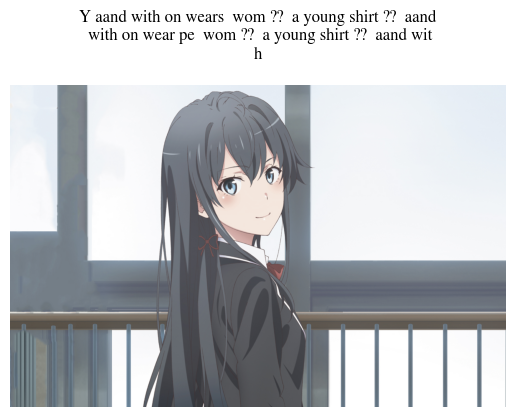

In [33]:
show_result()